<a href="https://colab.research.google.com/github/MonitSharma/Learn-Quantum-Machine-Learning/blob/main/Intro_to_QAOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to QAOA

The Quantum Approximate Optimization Algorithm (QAOA) is a widely-studied method for solving combinatorial optimization problems on NISQ devices. The applications of QAOA are broad and far-reaching, and the performance of the algorithm is of great interest to the quantum computing research community


![qaoa](https://pennylane.ai/qml/_images/qaoa_circuit.png)


The goal of this tutorial is to introduce the basic concepts of QAOA and to guide you through PennyLane’s built-in QAOA functionality. You will learn how to use time evolution to establish a connection between Hamiltonians and quantum circuits, and how to layer these circuits to create more powerful algorithms. These simple ingredients, together with the ability to optimize quantum circuits, are the building blocks of QAOA. By focusing on the fundamentals, PennyLane provides general and flexible capabilities that can be tailored and refined to implement QAOA for a wide variety of problems. In the last part of the tutorial, you will learn how to bring these pieces together and deploy a complete QAOA workflow to solve the minimum vertex cover problem. Let’s get started! 🎉


## Circuits and Hamiltonians

When considering quantum circuits, it is often convenient to define them by a series of quantum gates. But there are many instances where it is useful to think of a quantum circuit in terms of a Hamiltonian. Indeed, gates are physically implemented by performing time evolution under a carefully engineered Hamiltonian. These transformations are described by the time evolution operator, which is a unitary defined as:

$$U(H, \ t) \ = \ e^{-i H t / \hbar}.$$


-----

The time evolution operator is determined completely in terms of a Hamiltonian $H$ and a scalar $t$ representing time. In fact, any unitary $U$ can be written in the form $e^{i \gamma H}$ where $\gamma$ is a scalar and $H$ is a Hermitian operator, interpreted as a Hamiltonian. Thus, time evolution establishes a connection that allows us to describe quantum circuits in terms of Hamiltonians.





--------
--------

In general, implementing a quantum circuit that exactly exponentiates a Hamiltonian with many non-commuting terms, i.e., a Hamiltonian of the form:

$$H \ = \ H_1 \ + \ H_2 \ + \ H_3 \ + \ \cdots \ + \ H_N,$$

is very challenging. Instead, we can use the [Trotter-Suzuki](https://en.wikipedia.org/wiki/Lie_product_formula) decomposition formula

$$e^{A \ + \ B} \ \approx \ \Big(e^{A/n} e^{B/n}\Big)^{n},$$

to implement an *approximate* time-evolution unitary:

$$U(H, t, n) \ = \ \displaystyle\prod_{j \ = \ 1}^{n}
\displaystyle\prod_{k} e^{-i H_k t / n} \ \ \ \ \ \ \ \ \ \ H \
= \ \displaystyle\sum_{k} H_k,$$

where $U$ approaches $e^{-i H t}$ as $n$ becomes larger.

![larger](https://pennylane.ai/qml/_images/ham_circuit.png)



In PennyLane, this is implemented using the ApproxTimeEvolution() template. For example, let’s say we have the following Hamiltonian:







In [2]:
import pennylane as qml

H = qml.Hamiltonian(
    [1, 1, 0.5],
    [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
)
print(H)

  (1) [X0]
+ (1) [Z1]
+ (0.5) [X0 X1]


We can implement the approximate time-evolution operator corresponding to this Hamiltonian:

In [3]:
dev = qml.device('default.qubit', wires=2)

t = 1
n = 2

@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit, expansion_strategy='device')())

0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


## Layering circuits

Think of all the times you have copied a text or image, then pasted it repeatedly to create many duplicates. This is also a useful feature when designing quantum algorithms! The idea of repetition is ubiquitous in quantum computing: from amplitude amplification in [Grover’s algorithm](https://en.wikipedia.org/wiki/Grover%27s_algorithm) to layers in [quantum neural networks](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.1.033063) and [Hamiltonian simulation](https://en.wikipedia.org/wiki/Hamiltonian_simulation), repeated application of a circuit is a central tool in quantum algorithms.






![al](https://pennylane.ai/qml/_images/repeat.png)


--------


Circuit repetition is implemented in PennyLane using the `layer()` function. This method allows us to take a function containing either quantum operations, a template, or even a single quantum gate, and repeatedly apply it to a set of wires.


![im](https://pennylane.ai/qml/_images/qml_layer.png)


To create a larger circuit consisting of many repetitions, we pass the circuit to be repeated as an argument and specify the number of repetitions. For example, let’s say that we want to layer the following circuit three times:





In [4]:
def circ(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(param):
    circ(param)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)(0.5))

0: ──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X─┤  <Z>


We simply pass this function into the `layer()` function:

In [5]:
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)([0.3, 0.4, 0.5]))

0: ──RX(0.30)─╭●──RX(0.40)─╭●──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X──H────────╰X──H────────╰X─┤  <Z>


We have learned how time evolution can be used to create circuits from Hamiltonians, and how these can be layered to create longer circuits. We are now ready to explore QAOA.

## QAOA

The quantum approximate optimization algorithm (QAOA) is a general technique that can be used to find approximate solutions to combinatorial optimization problems, in particular problems that can be cast as searching for an optimal bitstring. QAOA consists of the following steps:


1.  Define a cost Hamiltonian $H_C$ such that its ground state encodes the solution to the optimization problem.

2. Define a mixer Hamiltonian $H_M$.

3. Construct the circuits $e^{-i \gamma H_C}$ and $e^{-i\alpha H_M}$. We call these the cost and mixer layers.

4. Choose a parameter $n \ge 1$ and build the circuit:

  $$U(\boldsymbol\gamma, \ \boldsymbol\alpha) \ = \ e^{-i \alpha_n H_M}
e^{-i \gamma_n H_C} \ ... \ e^{-i \alpha_1 H_M} e^{-i \gamma_1 H_C},$$
  consisting of repeated application of the cost and mixer layers.


5. Prepare an initial state, apply $U(\alpha, \gamma)$ and use classical techniques to optimize the parameters.


6. After the circuit has been optimized, measurements of the output state reveal approximate solutions to the optimization problem



In summary, the starting point of QAOA is the specification of cost and mixer Hamiltonians. We then use time evolution and layering to create a variational circuit and optimize its parameters. The algorithm concludes by sampling from the circuit to get an approximate solution to the optimization problem. Let’s see it in action! 



## Minimum Vertex Cover with QAOA

Our goal is to find the minimum vertex cover of a graph: a collection of vertices such that each edge in the graph contains at least one of the vertices in the cover. Hence, these vertices “cover” all the edges 👍. We wish to find the vertex cover that has the smallest possible number of vertices.

Vertex covers can be represented by a bit string where each bit denotes whether the corresponding vertex is present in the cover. For example, the bit string 01010 represents a cover consisting of the second and fourth vertex in a graph with five vertices.

![alt](https://pennylane.ai/qml/_images/minvc.png)


Import the dependencies:


In [6]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

We also define the four-vertex graph for which we want to find the minimum vertex cover:

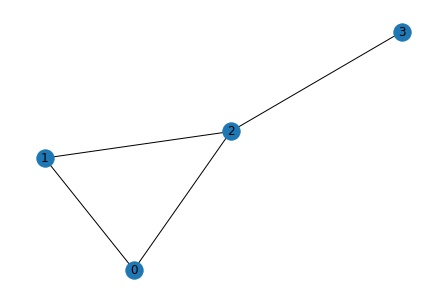

In [7]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

There are two minimum vertex covers of this graph: the vertices 0 and 2, and the vertices 1 and 2. These can be respectively represented by the bit strings 1010 and 0110. The goal of the algorithm is to sample these bit strings with high probability.

The PennyLane QAOA module has a collection of built-in optimization problems, including minimum vertex cover. For each problem, you can retrieve the cost Hamiltonian as well as a recommended mixer Hamiltonian. This makes it straightforward to obtain the Hamiltonians for specific problems while still permitting the flexibility to make other choices, for example by adding constraints or experimenting with different mixers.

In our case, the cost Hamiltonian has two ground states, |1010⟩ and |0110⟩, coinciding with the solutions of the problem. The mixer Hamiltonian is the simple, non-commuting sum of Pauli-X operations on each node of the graph:



In [8]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (-0.25) [Z3]
+ (0.5) [Z0]
+ (0.5) [Z1]
+ (1.25) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
Mixer Hamiltonian   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


A single layer of QAOA consists of time evolution under these Hamiltonians:

![](https://pennylane.ai/qml/_images/layer.png)


While it is possible to use `ApproxTimeEvolution()`, the QAOA module allows you to build the cost and mixer layers directly using the functions `cost_layer()` and `mixer_layer()`, which take as input the respective Hamiltonian and variational parameters:


In [9]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

We are now ready to build the full variational circuit. The number of wires is equal to the number of vertices of the graph. We initialize the state to an even superposition over all basis states. For this example, we employ a circuit consisting of two QAOA layers:

In [10]:
wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

Note that `layer()` allows us to pass variational parameters `params[0]` and `params[1]` into each layer of the circuit. That’s it! The last step is PennyLane’s specialty: optimizing the circuit parameters.

The cost function is the expectation value of $H_C$, which we want to minimize. We use the function `expval()` which returns the expectation value of the Hamiltonian with respect to the circuit’s output state. We also define the device on which the simulation is performed. We use the PennyLane-Qulacs plugin to run the circuit on the Qulacs simulator:

In [ ]:
!pip install pennylane-qulacs["cpu"]

In [15]:
dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

Finally, we optimize the cost function using the built-in `GradientDescentOptimizer()`. We perform optimization for seventy steps and initialize the parameters

In [16]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

Notice that we set each of the initial parameters to $0.5$. For demonstration purposes, we chose initial parameters that we know work fairly well, and don’t get stuck in any local minima.

The choice of initial parameters for a variational circuit is usually a difficult problem, so we won’t linger on it too much in this tutorial, but it is important to note that finding an initial set of parameters that work well for a few toy problems often yields good results for more complex instances of the algorithm as well.


Now, we can optimize the circuit:

In [17]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.59806352 0.94198485]
 [0.52797281 0.85552845]]


With the optimal parameters, we can now reconstruct the probability landscape. We redefine the full QAOA circuit with the optimal parameters, but this time we return the probabilities of measuring each bitstring:

In [18]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])


Finally, we can display a bar graph showing the probability of measuring each bitstring:

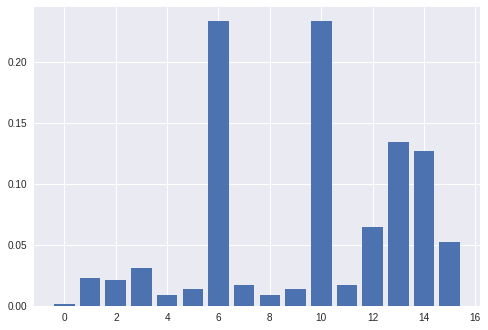

In [19]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

The states $|6⟩ = |0110⟩$ and $|10⟩ = |1010⟩$ have the highest probabilities of being measured, just as expected!


![](https://pennylane.ai/qml/_images/graph.png)

## Customizing QAOA

QAOA is not one-size-fits-all when it comes to solving optimization problems. In many cases, cost and mixer Hamiltonians will be very specific to one scenario, and not necessarily fit within the structure of the pre-defined problems in the `qaoa()` submodule. Luckily, one of the core principles behind the entire PennyLane library is customizability, and this principle hold true for QAOA submodule as well!

The QAOA workflow above gave us two optimal solutions: $|6⟩=|0110⟩$ and $|10⟩=|1010⟩$. What if we add a constraint that made one of these solutions “better” than the other? Let’s imagine that we are interested in solutions that minimize the original cost function, but also colour the first and third vertices $1$. A constraint of this form will favour $|10⟩$, making it the only true ground state.

It is easy to introduce constraints of this form in PennyLane. We can use the `edge_driver()` cost Hamiltonian to “reward” cases in which the first and last vertices of the graph are $0$:


In [20]:
reward_h = qaoa.edge_driver(nx.Graph([(0, 2)]), ['11'])

We then weigh and add the constraining term to the original minimum vertex cover Hamiltonian:

In [21]:
new_cost_h = cost_h + 2 * reward_h

Notice that PennyLane allows for simple addition and multiplication of Hamiltonian objects using inline arithmetic operations ➕ ➖ ✖️➗! Finally, we can use this new cost Hamiltonian to define a new QAOA workflow:

In [22]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, new_cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(new_cost_h)

params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.45959941 0.96095271]
 [0.27029962 0.78042396]]


We then reconstruct the probability landscape with the optimal parameters:

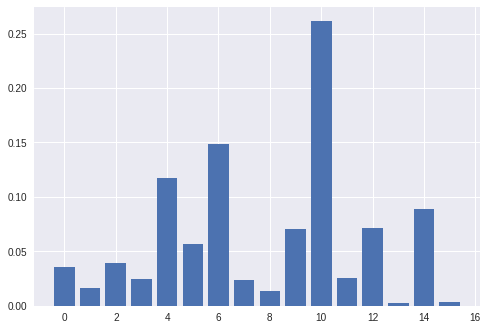

In [23]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

Just as we expected, the $|10⟩$ state is now favoured over $|6⟩$!

## Summary

We have learned how to use the PennyLane QAOA functionality, while also surveying some of the fundamental features that make the QAOA module simple and flexible.


![alt](https://pennylane.ai/qml/_images/qaoa_circuit.png)
